# Chapter 16: Handling Time Series


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - matplotlib: 3.2.0
>   - pandas: 1.0.1
>   - statsmodels: 0.11.1
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# Import required packages for this chapter
from pathlib import Path
import warnings

import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problems 16.1: Impact of September 11 on Air Travel in the United States
The Research and Innovative Technology Administration's Bureau of Transportation Statistics conducted a study to evaluate the impact of the September 11, 2001 terrorist attack on US transportation.  The 2006 study report and the data can be found at https://www.bts.gov/archive/publications/estimated_impacts_of_9_11_on_us_travel/index. The goal of the study was stated as follows:

> The purpose of this study is to provide a greater understanding of the passenger travel behavior patterns of persons making long distance trips before and after 9/11.

The report analyzes monthly passenger movement data between January 1990 and May 2004. Data on three monthly time series are given in file _Sept11Travel.csv_ for this period: 

1. Actual airline revenue passenger miles (Air), 
2. Rail passenger miles (Rail), and 
3. Vehicle miles traveled (Car).

In order to assess the impact of September 11, BTS took the following approach: using data before September 11, they forecasted future data (under the assumption of no terrorist attack). Then, they compared the forecasted series with the actual data to assess the impact of the event. Our first step, therefore, is to split each of the time series into two parts: pre- and post September 11. We now concentrate only on the earlier time series.

## Solution 16.1.a
Is the goal of this study descriptive or predictive?

The goal of the study is exploratory

## Solution 16.1.b
Plot each of the three pre-event time series (Air, Rail, Car).

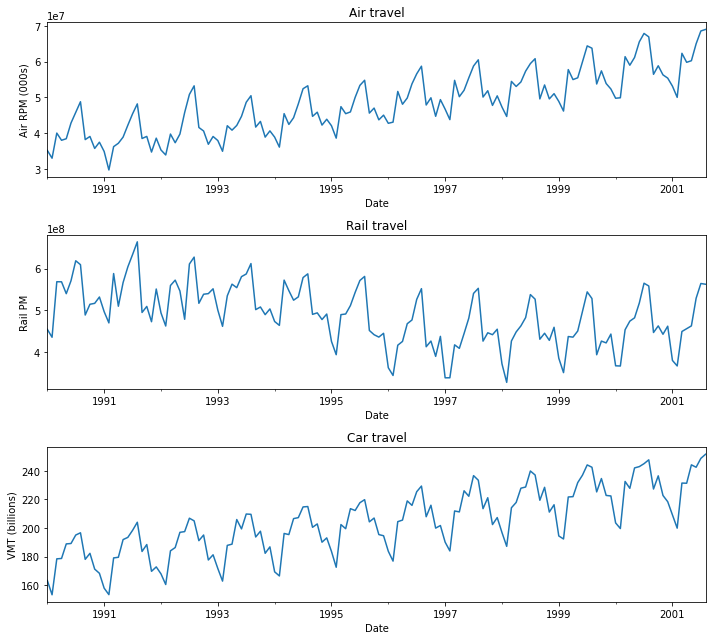

In [3]:
df = pd.read_csv(DATA / 'Sept11Travel.csv')

# convert the date information to a datetime object
df['Date'] = pd.to_datetime(df.Month, format='%b-%y')

air_ts = pd.Series(df['Air RPM (000s)'].values, index=df.Date, name='Air')
rail_ts = pd.Series(df['Rail PM'].values, index=df.Date, name='Rail')
car_ts = pd.Series(df['VMT (billions)'].values, index=df.Date, name='Car')

pre_air_ts = air_ts[:'2001-08-31']
post_air_ts = air_ts['2001-08-31':]
pre_rail_ts = rail_ts[:'2001-08-31']
post_rail_ts = rail_ts['2001-08-31':]
pre_car_ts = car_ts[:'2001-08-31']
post_car_ts = car_ts['2001-08-31':]

def createGraphs():
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,9))
    pre_air_ts.plot(ax=axes[0], title='Air travel')
    # post_air_ts.plot(ax=axes[0])
    axes[0].set_ylabel('Air RPM (000s)')

    pre_rail_ts.plot(ax=axes[1], title='Rail travel')
    # post_rail_ts.plot(ax=axes[1])
    axes[1].set_ylabel('Rail PM')

    pre_car_ts.plot(ax=axes[2], title='Car travel')
    # post_car_ts.plot(ax=axes[2])
    axes[2].set_ylabel('VMT (billions)')

    for ax in axes:
        ax.axvline(x='2001-09-11', ymin=0, ymax=1, linewidth=0.5)
    return axes

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    axes = createGraphs()

plt.tight_layout()
plt.show()

### Solution 16.1.b.i
What time series components appear from the plot?

Level, seasonality, trend, and noise are present in all 3 series. In the air 
series, there is a big drop in September.

### Solution 16.1.b.ii
What type of trend appears? Change the scale of the series, add trendlines and suppress seasonality to better visualize the trend pattern.

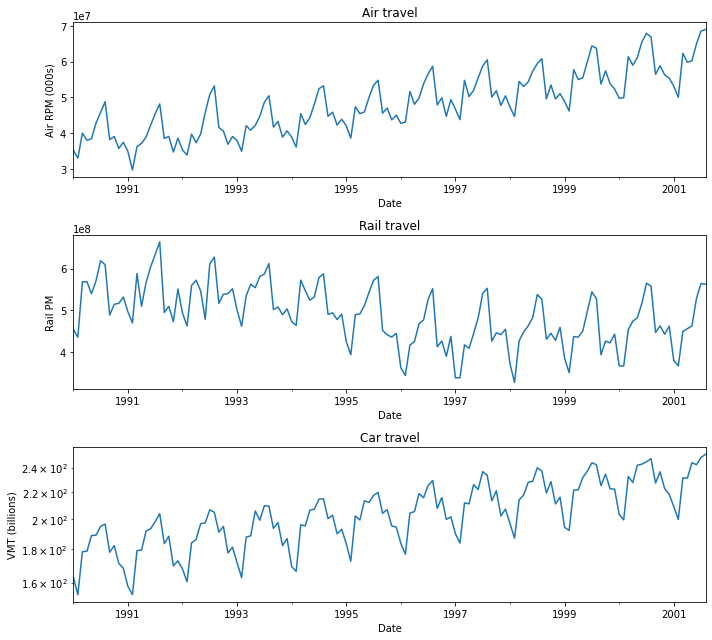

In [4]:
# Use logarithmic scale for y-axis
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    createGraphs()

plt.yscale('log')
plt.tight_layout()
plt.show()

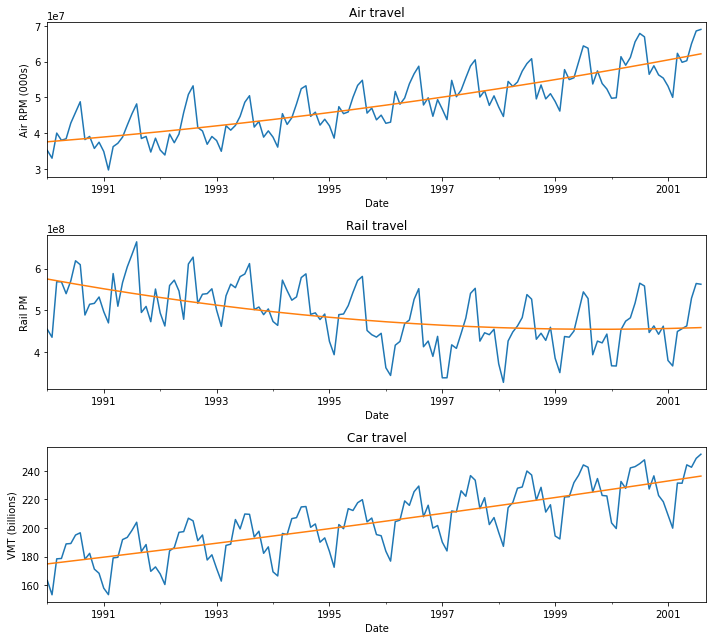

In [5]:
def addTrend(ts, outcome, ax):
    df = tsatools.add_trend(ts, trend='ctt')
    # fit a linear regression model to the time series
    model = sm.ols(formula=f'{outcome} ~ trend + trend_squared', data=df).fit()
    model.predict(df).plot(ax=ax)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    axes = createGraphs()
    addTrend(pre_air_ts, 'Air', axes[0])
    addTrend(pre_rail_ts, 'Rail', axes[1])
    addTrend(pre_car_ts, 'Car', axes[2])

plt.tight_layout()

Both Air and Vehicle show increasing linear trends, visible even without 
suppressing seasonality. Rail shows a more complex trend, initially steady, 
then declining, then rising. Separate linear trends might also be fit to each
of the 3 periods. Shifting to a logarithmic scale does not add information.

# Problem 16.2: Performance on Training and Validation Data
Two different models were fit to the same time series. The first 100 time periods were used for the training set and the last 12 periods were treated as a hold-out set. Assume that both models make sense practically and fit the data pretty well. The RMSE values for each of the models is given in the book.

```
                 Training Set        Validation Set
   Model A          543                    20
   Model B          869                    14
```

## Solution 16.2.a
Which model appears more useful for explaining the different components of this time series? Why?
  
A - the RMSE is much lower than for B, based on the training data (which are 
the bulk of the data).

## Solution 16.2.b
Which model appears to be more useful for forecasting purposes? Why?

B - the validation error, an estimate of predictive accuracy, is lower for model B than for model A.

# Problem 16.3: Forecasting Department Store Sales
The file _DepartmentStoreSales.csv_ contains data on the quarterly sales for a department store over a 6-year period (data courtesy of Chris Albright).

## Solution 16.3.a
Create a well-formatted time plot of the data.

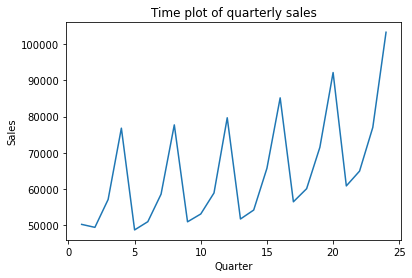

In [6]:
df = pd.read_csv(DATA / 'DepartmentStoreSales.csv')
df_ts = pd.Series(df['Sales'].values, index=df.Quarter)
ax = df_ts.plot(title='Time plot of quarterly sales')
ax.set_ylabel('Sales')
plt.show()

## Solution 16.3.b
Which of the four components (level, trend, seasonality, noise) seem to be present in this series?

All four components seem to be present (the noise component is relatively small).

# Problem 16.4: Shipments of Household Appliances
The file _ApplianceShipments.csv_ contains the series of quarterly shipments (in million $) of US household appliances between 1985 and 1989 (data courtesy of Ken Black).

## Solution 16.4.a
Create a well-formatted time plot of the data.

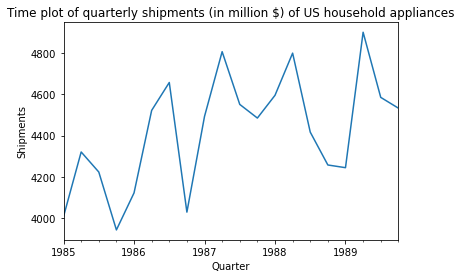

In [7]:
df = pd.read_csv(DATA / 'ApplianceShipments.csv')

# convert Quarter information into month-year
for q, m in ('Q1', '03'), ('Q2', '06'), ('Q3', '09'), ('Q4', '12'):
    df['Quarter'] = df['Quarter'].str.replace(q, m)
df['Quarter'] = pd.to_datetime(df.Quarter, format='%m-%Y')

df_ts = pd.Series(df['Shipments'].values, index=df.Quarter, name='shipments')
ax = df_ts.plot(title='Time plot of quarterly shipments (in million $) of US household appliances')
ax.set_ylabel('Shipments')
plt.show()

## Solution 16.4.b
Which of the four components (level, trend, seasonality, noise) seem to be present in this series?

Level, seasonality and noise are present (and possibly a slight upward trend).

# Problem 16.5: Canadian Manufacturing Workers Workhours
The time plot in the book describes the average annual number of weekly hours spent by Canadian manufacturing workers (data are available in _CanadianWorkHours.csv_ ---thanks to Ken Black for the data).

## Solution 16.5.a
Reproduce the time plot.

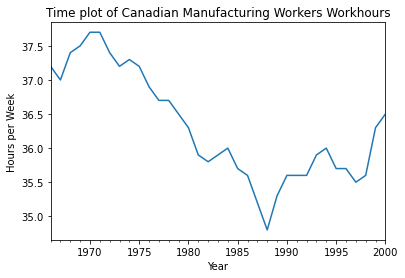

In [8]:
df = pd.read_csv(DATA / 'CanadianWorkHours.csv')
df_ts = pd.Series(df['Hours'].values, index=pd.to_datetime(df.Year, format='%Y'), name='shipments')
ax = df_ts.plot(title='Time plot of Canadian Manufacturing Workers Workhours')
ax.set_ylabel('Hours per Week')

plt.show()

## Solution 16.5.b
Which of the four components (level, trend, seasonality, noise) seem to be present in this series?

- Level (no dominant level)
- Trend (yes - down, then up)
- Seasonality (no)
- Noise (yes)

# Problem 16.6: Souvenir Sales
The file _SouvenirSales.csv_ contains monthly sales for a souvenir shop at a beach resort town in Queensland, Australia, between 1995--2001. (Source: Hyndman, R.J., Time Series Data Library, https://datamarket.com/data/list/?q=provider:tsdl. Accessed on 11/20/2018.)

Back in 2001, the store wanted to use the data to forecast sales for the next 12 months (year 2002). They hired an analyst to generate forecasts. The analyst first partitioned the data into training and validation sets, with the validation set containing the last 12 months of data (year 2001). She then fit a regression model to sales, using the training set.

## Solution 16.6.a
Create a well-formatted time plot of the data.

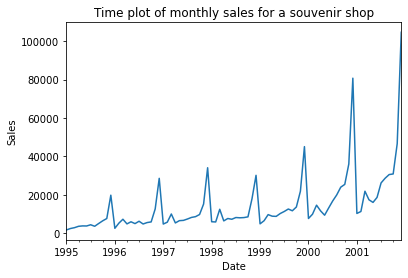

In [9]:
df = pd.read_csv(DATA / 'SouvenirSales.csv')
df_ts = pd.Series(df['Sales'].values, index=pd.to_datetime(df.Date, format='%b-%y'), name='souvenir')
ax = df_ts.plot(title='Time plot of monthly sales for a souvenir shop')
ax.set_ylabel('Sales')
plt.show()

## Solution 16.6.b
Change the scale on the `x`-axis, or on the `y`-axis, or on both to log-scale in order to achieve a linear relationship. Select the time plot that seems most linear.

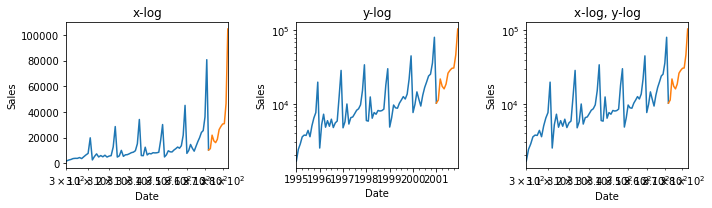

In [10]:
train_ts = df_ts[:'2001-01-01']
valid_ts = df_ts['2001-01-01':]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

ax = train_ts.plot(ax=axes[0], title='x-log')
valid_ts.plot(ax=ax)
ax.set_xscale('log')
ax.set_ylabel('Sales')

ax = train_ts.plot(ax=axes[1], title='y-log')
valid_ts.plot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Sales')

ax = train_ts.plot(ax=axes[2], title='x-log, y-log')
valid_ts.plot(ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()

Plotting log on the y-axis produces the most linear plot.

## Solution 16.6.c
Comparing the two time plots, what can be said about the type of trend in the data?

Since the log plot comes out linear, we can conclude that the actual trend in 
the data is exponential.

## Solution 16.6.d
Why were the data partitioned? Partition the data into the training and validation set as explained above.

The validation partition provides a benchmark against which to test
predictions, which is important because the goal of this effort is to forecast
future sales.

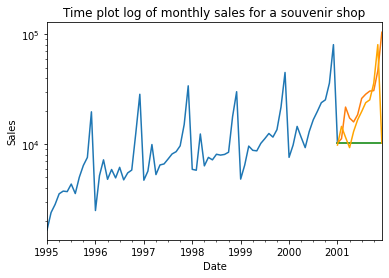

In [11]:
# Generate the naive and seasonal naive forecast
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)

ax = train_ts.plot(title='Time plot log of monthly sales for a souvenir shop')
valid_ts.plot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Sales')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')
plt.show()

# Problem 16.7: Shampoo Sales
The file _ShampooSales.csv_ contains data on the monthly sales of a certain shampoo over a 3-year period. Source: Hyndman, R.J., Time Series Data Library, http://data.is/TSDLdemo. Accessed on 11/18/18).

## Solution 16.7.a
Create a well-formatted time plot of the data.

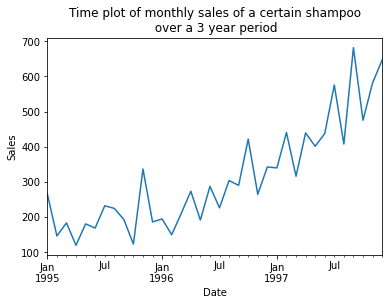

In [12]:
df = pd.read_csv(DATA / 'ShampooSales.csv')
df_ts = pd.Series(df['Shampoo Sales'].values, index=pd.to_datetime(df.Month, format='%b-%y'), name='souvenir')
ax = df_ts.plot(title='Time plot of monthly sales of a certain shampoo\n over a 3 year period')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

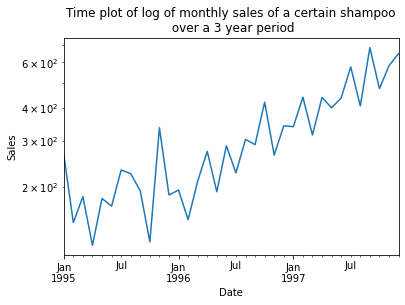

In [13]:
df = pd.read_csv(DATA / 'ShampooSales.csv')
df_ts = pd.Series(df['Shampoo Sales'].values, index=pd.to_datetime(df.Month, format='%b-%y'), name='souvenir')
ax = df_ts.plot(title='Time plot of log of monthly sales of a certain shampoo\n over a 3 year period')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
plt.show()

## Solution 16.7.b
Which of the four components (level, trend, seasonality, noise) seem to be present in this series?

Level, trend, noise

## Solution 16.7.c
Do you expect to see seasonality in sales of shampoo? Why?

No - the need to wash hair is not cyclical.

## Solution 16.7.d
If the goal is forecasting sales in future months, which of the
following steps should be taken? 

- Partition the data into training and validation sets
  - Yes
- Tweak the model parameters to obtain good fit to the validation data
  - Yes (but not to an extent that would result in overfitting)
- Look at MAPE and RMSE values for the training set
  - Yes, but this assessment is secondary to the assessment for the validation set.
- Look at MAPE and RMSE values for the validation set
  - Yes